In [25]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from sklearn.metrics import make_scorer

from sklearn.metrics import classification_report, accuracy_score
import random
random.seed(100)

import time
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


### Setting up SQL database

In [2]:
def create_sql_connection(server, database, username, password, driver='{ODBC Driver 17 for SQL Server}'):
    """
    Establish a connection to a SQL Server database using pyodbc.

    Parameters:
    - server (str): The SQL Server address (e.g., 'localhost' or server IP).
    - database (str): The name of the database you want to connect to.
    - username (str): SQL Server username.
    - password (str): SQL Server password.
    - driver (str): ODBC driver to use. Default is '{ODBC Driver 17 for SQL Server}'.s

    Returns:
    - conn: A pyodbc connection object if successful.
    """
    connection_string = f"""
        DRIVER={driver};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
    """
    try:
        conn = pyodbc.connect(connection_string)
        print("Connection established successfully!")
        return conn
    except Exception as e:
        print(f"Failed to connect to the database. Error: {e}")
        return None

In [3]:
def query_data(conn, query):
    """
    Execute a SQL query and fetch results as a pandas DataFrame.
    
    Parameters:
    - conn: A pyodbc connection object.
    - query (str): The SQL query to be executed.
    
    Returns:
    - df: A pandas DataFrame containing the query result.
    """
    start_time = time.time()  # Start time measurement
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        
        # Fetch all results from the query
        rows = cursor.fetchall()
        
        # Get column names from cursor
        columns = [desc[0] for desc in cursor.description]
        
        # Create a pandas DataFrame from the results
        df = pd.DataFrame.from_records(rows, columns=columns)
        
    except pyodbc.Error as e:
        print(f"Error executing query: {e}")
        return None
    
    finally:
        cursor.close()
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time  # Calculate execution time
    
    # Print the DataFrame and execution time
    print(f"Query executed in: {execution_time:.4f} seconds")
    
    return df  

In [4]:
server = 'ROHIT'     
database = 'MedicareClaim'  
username = 'rohit_kosamkar'       
password = 'September@2024' 

In [5]:
# Establish connection
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


In [6]:
bene_df  = query_data(conn, "select top 10 * from beneficiarydata")
bene_df.head()

Query executed in: 0.0946 seconds


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NA,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NA,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NA,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NA,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NA,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


### Set Up MLflow Tracking with SQL Database

In [7]:
import mlflow
import mlflow.sklearn
from sqlalchemy import create_engine

try:
    # Set MLflow Tracking URI using SQL Server and Windows Authentication
    mlflow.set_tracking_uri("mssql+pyodbc://ROHIT/MedicareClaim?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")
 
    # Name the experiment
    mlflow.set_experiment("MedicareClaim_Fraud_Detection")
except Exception as e:
    print(f"Connection failed: {e}")

2024/10/18 13:12:23 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/10/18 13:12:23 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl MSSQLImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Context impl MSSQLImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.


In [8]:
import mlflow
import mlflow.sklearn
from sqlalchemy import create_engine, text
import pandas as pd

# Use a raw string to handle backslashes in the server name
mlflow_tracking_uri = (
    r"mssql+pyodbc://ROHIT/MedicareClaim"
    "?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)
 
# Set the MLflow Tracking URI
mlflow.set_tracking_uri(mlflow_tracking_uri)
 
try:
    # Create an SQLAlchemy engine
    engine = create_engine(mlflow_tracking_uri)
 
    # Test the connection by running a simple query
    with engine.connect() as connection:
        # Use the text() function to create a SQL statement
        query = text("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES")
        result = connection.execute(query)
 
        # Fetch all the results and display them
        tables = result.fetchall()
 
        # Print the list of tables
        print("Connection successful! Here are the tables in the database:")
        for table in tables:
            print(table[0])
 
    # Name the experiment (if connection is successful)
    mlflow.set_experiment("MedicareClaim_Fraud_Detection")
 
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Here are the tables in the database:
Beneficiarydata
experiments
runs
tags
metrics
params
alembic_version
experiment_tags
latest_metrics
registered_models
model_versions
registered_model_tags
model_version_tags
registered_model_aliases
datasets
inputs
input_tags
trace_info
trace_tags
trace_request_metadata


### Importing data

In [8]:
data = pd.read_csv(r'../data/interim/model_data_new.csv')
data.shape

(557240, 50)

In [9]:
del data['Unnamed: 0']
data.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,SamePhysician,OPD_Flag,PotentialFraud,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,BirthYear,Age,Alive,ChronicDisease_Count,Total_Claims_Per_Bene,Avg_Reimbursement_Per_Bene,Age_At_Claim,Multiple_Chronic_Conditions,Claim_To_Deductible_Ratio,Total_Annual_Reimbursement,Avg_Reimbursement_By_Provider,Provider_Claim_Frequency,High_Risk_Provider
0,BENE11001,CLM46614,PRV55912,690.0,1068.0,6,6,9.0,0.0,No,No,1,1900-01-01,2009-12-01,Male,White,No,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,14250.0,2670.0,60.0,70.0,1943,67.0,0,7.0,3,690.0,67.0,1,0.645463,14310.0,0.0,107,0
1,BENE11001,CLM66048,PRV55907,690.0,1068.0,2,2,3.0,1.0,Yes,No,0,1900-01-01,2009-12-01,Male,White,No,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,14250.0,2670.0,60.0,70.0,1943,67.0,0,7.0,3,690.0,67.0,1,0.645463,14310.0,0.0,243,0
2,BENE11001,CLM68358,PRV56046,690.0,1068.0,3,3,6.0,0.0,No,No,0,1900-01-01,2009-12-01,Male,White,No,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,14250.0,2670.0,60.0,70.0,1943,67.0,0,7.0,3,690.0,67.0,1,0.645463,14310.0,0.0,20,0
3,BENE11011,CLM38412,PRV52405,690.0,1068.0,8,8,9.0,1.0,No,No,0,1900-01-01,2009-12-01,Female,Black or African American,No,Alabama,360,12,12,No,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,5000.0,1068.0,250.0,320.0,1914,96.0,0,6.0,4,217.5,96.0,1,0.645463,5250.0,0.0,89,0
4,BENE11014,CLM63689,PRV56614,690.0,1068.0,17,17,9.0,1.0,No,No,0,1900-01-01,2009-12-01,Female,White,Yes,Utah,780,12,12,No,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,14250.0,2136.0,120.0,100.0,1938,72.0,0,5.0,2,375.0,72.0,1,0.645463,14370.0,0.0,24,0


In [10]:
data.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'ClaimPeriod', 'TimeInHptal', 'Diagnosis Count',
       'Procedures Count', 'SamePhysician', 'OPD_Flag', 'PotentialFraud',
       'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'BirthYear', 'Age', 'Alive',
       'ChronicDisease_Count', 'Total_Claims_Per_Bene',
       'Avg_Reimbursement_Per_Bene', 'Age_At_Claim',
       'Multiple_Chronic_Conditions', 'Claim_To_D

In [11]:
imp_cols = ['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'ClaimPeriod', 'TimeInHptal', 'Diagnosis Count',
       'Procedures Count', 'SamePhysician', 'OPD_Flag', 'PotentialFraud',
        'Gender', 'Race', 'RenalDiseaseIndicator', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt',  'Age',
       'ChronicDisease_Count', 'Total_Claims_Per_Bene',
       'Avg_Reimbursement_Per_Bene', 'Age_At_Claim',
       'Multiple_Chronic_Conditions', 'Claim_To_Deductible_Ratio',
       'Total_Annual_Reimbursement', 'Avg_Reimbursement_By_Provider',
       'Provider_Claim_Frequency', 'High_Risk_Provider']

In [63]:
# data_encoded.drop(columns={'ClaimID', 'Provider'}).corr().to_clipboard()

In [12]:
data['PotentialFraud'].value_counts()

PotentialFraud
0    344978
1    212262
Name: count, dtype: int64

In [13]:
data = data[imp_cols]
data.shape

(557240, 43)

In [14]:
data.select_dtypes(include='object').columns

Index(['BeneID', 'ClaimID', 'Provider', 'SamePhysician', 'OPD_Flag', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'],
      dtype='object')

In [15]:
### One-hot encoding
cat_cols = ['SamePhysician', 'OPD_Flag', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

data_encoded = pd.get_dummies(data, columns = cat_cols,drop_first=True)
data_encoded.shape

(557240, 45)

In [16]:
data_encoded.head(2)
del data_encoded['BeneID']

In [50]:
# del data_encoded['Provider_Claim_Frequency']

In [17]:
data_encoded['PotentialFraud'].value_counts(normalize=True)

PotentialFraud
0    0.619083
1    0.380917
Name: proportion, dtype: float64

In [18]:
# X = data_encoded.drop(columns='PotentialFraud')
X = data_encoded[['ClaimID', 'Provider','Total_Claims_Per_Bene',
    'TimeInHptal',
    'Provider_Claim_Frequency',
    'ChronicCond_stroke_Yes',
    'DeductibleAmtPaid',
    'NoOfMonths_PartBCov',
    'NoOfMonths_PartACov',
    'OPD_Flag_Yes',
    'Diagnosis Count',
    'ChronicDisease_Count', 'Age']]
y = data_encoded['PotentialFraud']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify=y)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (390068, 13)
X_test: (167172, 13)
y_train: (390068,)
y_test: (167172,)


### MLFLOW

In [109]:
# Set the experiment name
experiment_name = "MedicareClaim_Fraud_Detection"
mlflow.set_experiment(experiment_name)  # Set or create the experiment


<Experiment: artifact_location='file:///d:/workspace/git_projects/Medicare-Claim-Fraud-Detection/scripts/mlruns/1', creation_time=1728100769590, experiment_id='1', last_update_time=1728100769590, lifecycle_stage='active', name='MedicareClaim_Fraud_Detection', tags={}>

In [128]:
# # List of models to evaluate
# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
#     "Decision Tree Classifier": DecisionTreeClassifier(),
#     "Random Forest Classifier": RandomForestClassifier(random_state=42),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# }

In [129]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [123]:
# Hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    "Decision Tree Classifier": {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest Classifier": {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    }
}

In [126]:
# Custom function to evaluate models with hyperparameter tuning
def evaluate_models(models, param_grids, X_train, X_test, y_train, y_test):
    # Drop non-predictive columns
    X_train_processed = X_train.drop(['ClaimID', 'Provider'], axis=1)
    X_test_processed = X_test.drop(['ClaimID', 'Provider'], axis=1)
    
    # Define scoring metric to optimize (maximize recall)
    scoring = make_scorer(recall_score)

    # Iterate through each model and perform hyperparameter tuning
    for model_name, model in models.items():
        with mlflow.start_run():
            print(f"\nTuning hyperparameters for: {model_name}")

            # Perform GridSearchCV for hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring=scoring, n_jobs=-1)
            grid_search.fit(X_train_processed, y_train)

            # Get the best model after hyperparameter tuning
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_

            # Log best hyperparameters
            mlflow.log_params(best_params)

            # Make predictions with the best model
            y_train_pred = best_model.predict(X_train_processed)
            y_test_pred = best_model.predict(X_test_processed)

            # Calculate metrics
            metrics = {
                'accuracy': {
                    'train': accuracy_score(y_train, y_train_pred),
                    'test': accuracy_score(y_test, y_test_pred)
                },
                'precision': {
                    'train': precision_score(y_train, y_train_pred),
                    'test': precision_score(y_test, y_test_pred)
                },
                'recall': {
                    'train': recall_score(y_train, y_train_pred),
                    'test': recall_score(y_test, y_test_pred)
                },
                'roc_auc': {
                    'train': roc_auc_score(y_train, best_model.predict_proba(X_train_processed)[:, 1]),
                    'test': roc_auc_score(y_test, best_model.predict_proba(X_test_processed)[:, 1])
                }
            }

            # Log metrics with model name included
            for metric_name, metric_values in metrics.items():
                mlflow.log_metric(f"{model_name}_train_{metric_name}", metric_values['train'])
                mlflow.log_metric(f"{model_name}_test_{metric_name}", metric_values['test'])

            # Log feature importance if applicable
            if hasattr(best_model, 'feature_importances_'):
                feature_importances = best_model.feature_importances_
            elif hasattr(best_model, 'coef_'):
                feature_importances = best_model.coef_[0]
            else:
                feature_importances = None

            if feature_importances is not None:
                # Create a DataFrame for better logging
                importance_df = pd.DataFrame({
                    'Feature': X_train_processed.columns,
                    'Importance': feature_importances
                }).sort_values(by='Importance', ascending=False)

                # Log the feature importances as an artifact
                importance_file_path = f"mlruns/{model_name}_feature_importances.csv"
                importance_df.to_csv(importance_file_path, index=False)
                mlflow.log_artifact(importance_file_path)

            # Log the best model
            mlflow.sklearn.log_model(best_model, model_name)

            # End the run
            mlflow.end_run()

In [127]:
# Call the function with the models, param grids, and training/testing datasets
evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)


Tuning hyperparameters for: Logistic Regression


d:\workspace\git_projects\Medicare-Claim-Fraud-Detection\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2024/10/05 14:01:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Tuning hyperparameters for: Decision Tree Classifier


2024/10/05 14:04:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Tuning hyperparameters for: Random Forest Classifier


KeyboardInterrupt: 

In [52]:
# os.getcwd()

In [162]:
# def evaluate_models(models, X_train, X_test, y_train, y_test):
#     # Drop non-predictive columns
#     X_train_processed = X_train.drop(['ClaimID', 'Provider'], axis=1)
#     X_test_processed = X_test.drop(['ClaimID', 'Provider'], axis=1)

#     # Iterate through each model
#     for model_name, model in models.items():
#         with mlflow.start_run():
#             # Train the models
#             model.fit(X_train_processed, y_train)

#             # Make predictions
#             y_train_pred = model.predict(X_train_processed)
#             y_test_pred = model.predict(X_test_processed)

#             # Calculate metrics
#             metrics = {
#                 'accuracy': {
#                     'train': accuracy_score(y_train, y_train_pred),
#                     'test': accuracy_score(y_test, y_test_pred)
#                 },
#                 'precision': {
#                     'train': precision_score(y_train, y_train_pred),
#                     'test': precision_score(y_test, y_test_pred)
#                 },
#                 'recall': {
#                     'train': recall_score(y_train, y_train_pred),
#                     'test': recall_score(y_test, y_test_pred)
#                 },
#                 'roc_auc': {
#                     'train': roc_auc_score(y_train, model.predict_proba(X_train_processed)[:, 1]),
#                     'test': roc_auc_score(y_test, model.predict_proba(X_test_processed)[:, 1])
#                 }
#             }

#             # Log metrics with model name included
#             for metric_name, metric_values in metrics.items():
#                 mlflow.log_metric(f"{model_name}_train_{metric_name}", metric_values['train'])
#                 mlflow.log_metric(f"{model_name}_test_{metric_name}", metric_values['test'])

#             # Log feature importance if applicable
#             if hasattr(model, 'feature_importances_'):
#                 feature_importances = model.feature_importances_
#             elif hasattr(model, 'coef_'):
#                 feature_importances = model.coef_[0]
#             else:
#                 feature_importances = None

#             if feature_importances is not None:
#                 # Create a DataFrame for better logging
#                 importance_df = pd.DataFrame({
#                     'Feature': X_train_processed.columns,
#                     'Importance': feature_importances
#                 }).sort_values(by='Importance', ascending=False)

#                 # Log the feature importances as an artifact
#                 importance_file_path = f"mlruns/{model_name}_feature_importances.csv"
#                 importance_df.to_csv(importance_file_path, index=False)
#                 mlflow.log_artifact(importance_file_path)

#             # Log the model
#             mlflow.sklearn.log_model(model, model_name)

#             # End the run
#             mlflow.end_run()

In [112]:
# # Call the function to evaluate the models
# evaluate_models(models, X_train, X_test, y_train, y_test)

##### Run this in CMD:

mlflow ui --backend-store-uri "mssql+pyodbc://ROHIT/MedicareClaim?driver=ODBC+Driver+17+for+SQL+Server`&trusted_connection=yes"


### Best Model

In [23]:
# Logistic Regression
start_time = time.time()

# Initialize and fit the Logistic Regression model
# rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split = 7, min_samples_leaf= 2, random_state=42)
lr_model = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
lr_model.fit(X_train.drop(['ClaimID', 'Provider'], axis=1), y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train.drop(['ClaimID', 'Provider'], axis=1))
y_pred_lr_test = lr_model.predict(X_test.drop(['ClaimID', 'Provider'], axis=1))

end_time = time.time()
# Time taken
execution_time = end_time - start_time
print('Execution time: ', execution_time)

# Metrics for Training Data
print("\nLogistic Regression Training Report:")
print(classification_report(y_train, y_pred_lr_train))
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_lr_train)}")
print(f"Training Precision: {precision_score(y_train, y_pred_lr_train)}")
print(f"Training Recall: {recall_score(y_train, y_pred_lr_train)}")
print(f"Training F1 Score: {f1_score(y_train, y_pred_lr_train)}")

# Metrics for Test Data
print("\nLogistic Regression Test Report:")
print(classification_report(y_test, y_pred_lr_test))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr_test)}")
print(f"Test Precision: {precision_score(y_test, y_pred_lr_test)}")
print(f"Test Recall: {recall_score(y_test, y_pred_lr_test)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_lr_test)}")

Execution time:  1.604551076889038

Logistic Regression Training Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86    241485
           1       0.82      0.66      0.74    148583

    accuracy                           0.82    390068
   macro avg       0.82      0.79      0.80    390068
weighted avg       0.82      0.82      0.81    390068

Training Accuracy: 0.8179496908231385
Training Precision: 0.8239332514845531
Training Recall: 0.663952134497217
Training F1 Score: 0.7353419102848879

Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86    103493
           1       0.82      0.67      0.74     63679

    accuracy                           0.82    167172
   macro avg       0.82      0.79      0.80    167172
weighted avg       0.82      0.82      0.81    167172

Test Accuracy: 0.8176488885698562
Test Precision: 0.8219752080544724
Test Recall: 0.66539

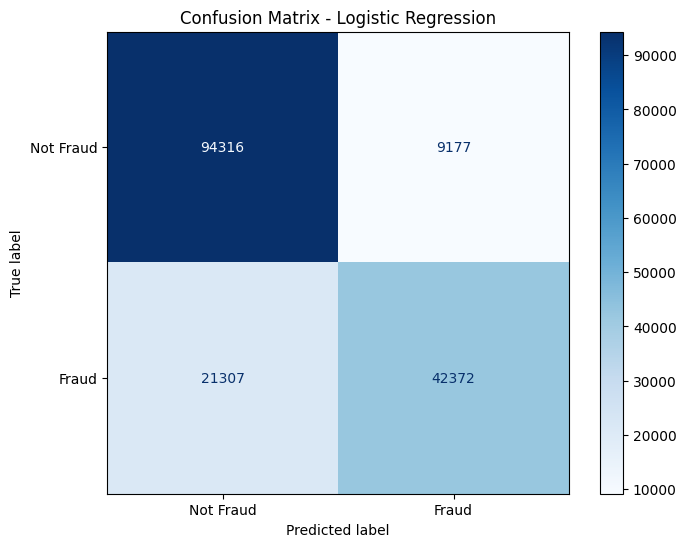

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr_test)

# Create display with custom class labels: 0 = Not Fraud, 1 = Fraud
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [21]:
importances = lr_model.coef_[0]
feature_names = X.drop(['ClaimID', 'Provider'], axis=1).columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

                     Feature  Importance
0      Total_Claims_Per_Bene    0.012159
1                TimeInHptal    0.005160
2   Provider_Claim_Frequency    0.002984
4          DeductibleAmtPaid    0.002101
3     ChronicCond_stroke_Yes    0.001303
10                       Age   -0.003971
7               OPD_Flag_Yes   -0.009254
9       ChronicDisease_Count   -0.012926
8            Diagnosis Count   -0.013885
6        NoOfMonths_PartACov   -0.094009
5        NoOfMonths_PartBCov   -0.097744


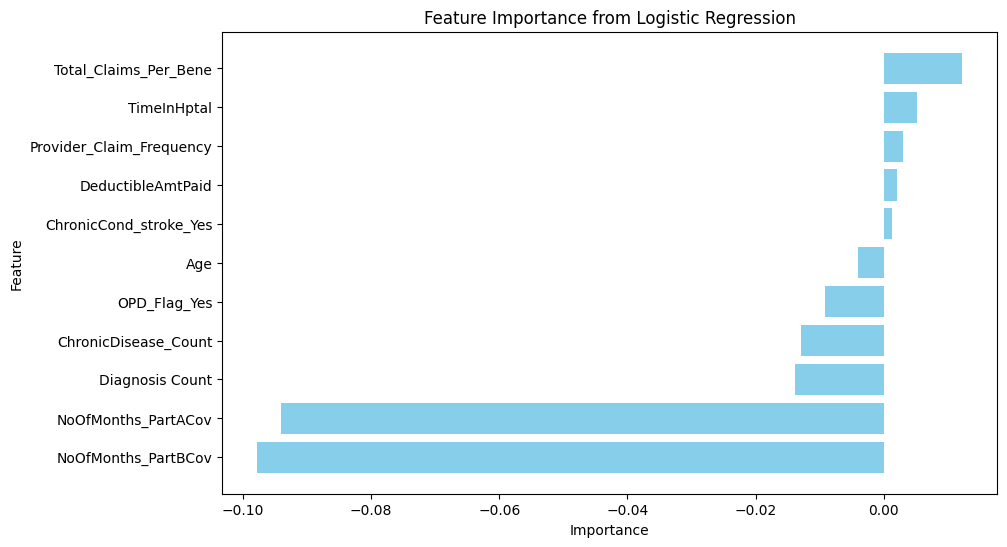

In [22]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

In [101]:
# feature_importance_df['Feature'][:15].to_list()

In [84]:
# Step 1: Get probabilities for the positive class (class 1) in the test data
lr_probabilities = lr_model.predict_proba(X_test.drop(['ClaimID', 'Provider'], axis=1))[:, 1]  # Probabilities for class 1


In [57]:
# del X_test['Fraud_Deciles']

In [85]:
# Step 2: Add the probabilities to the test dataset
X_test['Fraud_Probabilities'] = lr_probabilities

# Step 3: Create deciles using pd.qcut (10 deciles)
X_test['Fraud_Deciles'] = pd.qcut(X_test['Fraud_Probabilities'].rank(method='first', ascending=False), q=10, labels=range(1, 11))

In [86]:
X_test.head()

,ClaimID,Provider,Total_Claims_Per_Bene,TimeInHptal,Provider_Claim_Frequency,ChronicCond_stroke_Yes,DeductibleAmtPaid,NoOfMonths_PartBCov,NoOfMonths_PartACov,OPD_Flag_Yes,Diagnosis Count,ChronicDisease_Count,Age,Fraud_Probabilities,Fraud_Deciles
179696,CLM518049,PRV52066,9,0,1455,False,0.0,12,12,True,2.0,2.0,40.0,0.872108,2
213539,CLM749066,PRV52571,2,0,508,False,0.0,12,12,True,1.0,6.0,84.0,0.230751,5
439103,CLM287490,PRV55086,14,0,78,False,0.0,12,12,True,1.0,6.0,95.0,0.084315,9
27301,CLM68132,PRV54074,4,4,112,False,1068.0,12,12,False,1.0,2.0,89.0,0.486141,4
330820,CLM520978,PRV52934,10,0,32,False,0.0,12,12,True,2.0,6.0,68.0,0.077437,10


In [87]:
X_test['Actual_Label'] = y_test.values
X_test['Predicted_Label'] = y_pred_lr_test

X_test['Correctly_Classified'] = (X_test['Actual_Label'] == X_test['Predicted_Label']).astype(int)


In [88]:
X_test.groupby('Fraud_Deciles').agg(
    total_cases=('Correctly_Classified', 'size'),
    correct_classifications=('Correctly_Classified', 'sum')
)

C:\Users\rohit\AppData\Local\Temp\ipykernel_35332\4276293058.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test.groupby('Fraud_Deciles').agg(


,total_cases,correct_classifications
Fraud_Deciles,,
1,16718,16718
2,16717,16419
3,16717,8662
4,16717,11084
5,16717,11053
6,16717,12844
7,16717,13566
8,16717,14723
9,16717,15439


In [89]:
# X_test[['ClaimID', 'Provider','Fraud_Probabilities', 'Fraud_Deciles', 'Actual_Label',
#        'Predicted_Label', 'Correctly_Classified' ]].to_clipboard()

In [90]:
X_test.columns

Index(['ClaimID', 'Provider', 'Total_Claims_Per_Bene', 'TimeInHptal',
       'Provider_Claim_Frequency', 'ChronicCond_stroke_Yes',
       'DeductibleAmtPaid', 'NoOfMonths_PartBCov', 'NoOfMonths_PartACov',
       'OPD_Flag_Yes', 'Diagnosis Count', 'ChronicDisease_Count', 'Age',
       'Fraud_Probabilities', 'Fraud_Deciles', 'Actual_Label',
       'Predicted_Label', 'Correctly_Classified'],
      dtype='object')

### Storing deciles for prediction

In [91]:
# Step 1: Calculate the min and max probability for each decile
decile_prob_ranges = X_test.groupby('Fraud_Deciles').agg(
    min_probability=('Fraud_Probabilities', 'min'),
    max_probability=('Fraud_Probabilities', 'max')
)

# Display the decile probability ranges
print(decile_prob_ranges)


               min_probability  max_probability
Fraud_Deciles                                  
1                     0.972319         1.000000
2                     0.783750         0.972316
3                     0.517324         0.783739
4                     0.354855         0.517322
5                     0.226100         0.354855
6                     0.148685         0.226097
7                     0.113433         0.148682
8                     0.092607         0.113432
9                     0.079122         0.092607
10                    0.055088         0.079122


C:\Users\rohit\AppData\Local\Temp\ipykernel_35332\2418567526.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_prob_ranges = X_test.groupby('Fraud_Deciles').agg(


In [92]:
decile_prob_ranges

,min_probability,max_probability
Fraud_Deciles,,
1,0.972319,1.000000
2,0.783750,0.972316
3,0.517324,0.783739
4,0.354855,0.517322
5,0.226100,0.354855
6,0.148685,0.226097
7,0.113433,0.148682
8,0.092607,0.113432
9,0.079122,0.092607


In [93]:
decile_prob_ranges.to_csv(r'../models/decile_prob_ranges_logistic_regression.csv')

In [66]:
os.getcwd()

'd:\\workspace\\git_projects\\Medicare-Claim-Fraud-Detection\\scripts'

In [67]:
import pickle

model_filename = '../models/fraud_claim_logistic_model.pkl'

# Save the model to a file in .pkl format
with open(model_filename, 'wb') as file:
    pickle.dump(lr_model, file)

print(f"Model saved as {model_filename}")

Model saved as ../models/fraud_claim_logistic_model.pkl


In [125]:
def categorize_probabilities(prob_column):
    conditions = [
        prob_column > 0.354855,    # High Risk
        (prob_column > 0.148682) & (prob_column <= 0.354855),  # Medium Risk
        prob_column <= 0.148682      # Low Risk
    ]
    
    choices = ['High', 'Medium', 'Low']
    
    # Apply the conditions to create the categories
    return pd.cut(prob_column, bins=[0, 0.148682, 0.354855, 1.0], labels=['Low', 'Medium', 'High'], right=False)

In [126]:
X_test['Risk_Category'] = categorize_probabilities(X_test['Fraud_Probabilities'])

In [127]:
X_test['Risk_Category'].value_counts()

Risk_Category
High      66870
Low       66869
Medium    33433
Name: count, dtype: int64

In [128]:
X_test[X_test['Fraud_Probabilities']>=0.35].shape

(67163, 19)

In [120]:
X_test.head()

,ClaimID,Provider,Total_Claims_Per_Bene,TimeInHptal,Provider_Claim_Frequency,ChronicCond_stroke_Yes,DeductibleAmtPaid,NoOfMonths_PartBCov,NoOfMonths_PartACov,OPD_Flag_Yes,Diagnosis Count,ChronicDisease_Count,Age,Fraud_Probabilities,Fraud_Deciles,Actual_Label,Predicted_Label,Correctly_Classified,Risk_Category
179696,CLM518049,PRV52066,9,0,1455,False,0.0,12,12,True,2.0,2.0,40.0,0.872108,2,1,1,1,High
213539,CLM749066,PRV52571,2,0,508,False,0.0,12,12,True,1.0,6.0,84.0,0.230751,5,0,0,1,Medium
439103,CLM287490,PRV55086,14,0,78,False,0.0,12,12,True,1.0,6.0,95.0,0.084315,9,0,0,1,Low
27301,CLM68132,PRV54074,4,4,112,False,1068.0,12,12,False,1.0,2.0,89.0,0.486141,4,1,0,0,High
330820,CLM520978,PRV52934,10,0,32,False,0.0,12,12,True,2.0,6.0,68.0,0.077437,10,0,0,1,Low


In [112]:
X_test.to_csv('../models/test_results_logistic.csv')

In [113]:
X_train.head()

,ClaimID,Provider,Total_Claims_Per_Bene,TimeInHptal,Provider_Claim_Frequency,ChronicCond_stroke_Yes,DeductibleAmtPaid,NoOfMonths_PartBCov,NoOfMonths_PartACov,OPD_Flag_Yes,Diagnosis Count,ChronicDisease_Count,Age,Fraud_Probabilities,Fraud_Deciles,Actual_Label,Predicted_Label,Correctly_Classified,Risk_Category
199858,CLM638937,PRV57528,2,0,401,False,0.0,12,12,True,5.0,8.0,64.0,0.178672,6,1,0,0,Medium
59870,CLM113529,PRV52160,8,0,53,False,0.0,12,12,True,0.0,6.0,82.0,0.078192,10,0,0,1,Low
492990,CLM567031,PRV56284,7,0,67,False,0.0,12,12,True,3.0,6.0,67.0,0.081688,9,0,0,1,Low
350139,CLM392038,PRV52098,12,0,469,False,0.0,12,12,True,2.0,4.0,72.0,0.242456,5,0,0,1,Medium
302789,CLM134014,PRV52337,10,0,773,False,0.0,12,12,True,1.0,1.0,81.0,0.440428,4,1,0,0,High


In [114]:
lr_probabilities = lr_model.predict_proba(X_train.drop(['ClaimID', 'Provider'], axis=1))[:, 1]  # Probabilities for class 1

# Step 2: Add the probabilities to the test dataset
X_train['Fraud_Probabilities'] = lr_probabilities

# Step 3: Create deciles using pd.qcut (10 deciles)
X_train['Fraud_Deciles'] = pd.qcut(X_train['Fraud_Probabilities'].rank(method='first', ascending=False), q=10, labels=range(1, 11))




ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Actual_Label
- Correctly_Classified
- Fraud_Deciles
- Fraud_Probabilities
- Predicted_Label
- ...


In [104]:
X_train['Actual_Label'] = y_train.values
X_train['Predicted_Label'] = y_pred_lr_train

X_train['Correctly_Classified'] = (X_train['Actual_Label'] == X_train['Predicted_Label']).astype(int)


In [115]:
X_train['Risk_Category'] = categorize_probabilities(X_train['Fraud_Probabilities'])

In [116]:
X_train.head()
X_train.shape

(390068, 19)

In [117]:
X_train.to_csv('../models/train_results_logistic.csv')